# Adult Census Income Classification - Ludwig API

We recommend using a GPU runtime for this example. In the Colab menu bar, choose Runtime > Change Runtime Type and choose GPU under Hardware Accelerator.

In this notebook, we will show how to use the Ludwig CLI to:

1. Download a Dataset
1. Train a Ludwig Model
1. Evaluate the trained model
1. Visualize training and test metrics
1. Make predictions on New Data

In [ ]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
%pip uninstall -y tensorflow --quiet
%pip install ludwig --quiet
%pip install ludwig[viz] --quiet

# Download Dataset

[Adult Census Income](https://archive.ics.uci.edu/ml/datasets/adult) is an extract of 1994 Census data for predicting whether a person's income exceeds $50K per year.  The data set consists of over 49K records with 14 attributes with missing data.


The columns in the dataset are

| column         | description                                                  |
|----------------|--------------------------------------------------------------|
| age            | numeric variable, age of person                              |
| workclass      | categorical variable, Type of empolyment                     |
| fnlwgt         | numeric variable, no defintion                               |
| education      | categorical variable, education level                        |
| education-num  | nmeric variable, no definition                               |
| marital-status | categorical variable, marital status                         |
| occupation     | categorical variable, occupation                             |
| relationship   | categorical variable, Relationship to household              |
| race           | categorical variable, race                                   |
| sex            | categorical variable, gender                                 |
| capital-gain   | numeric variable, no definition                              |
| capital-loss   | numeric variable, no definition                              |
| hours-per-week | numeric variable, hours worked per week                      |
| native-country | categorical variable, Country of origin                      |
| income         | binary variable, " <=50K" or " >50K"                         |
| split          | numeric variable, indicating data split training(0), test(2) |


In [ ]:
from ludwig.datasets import adult_census_income

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = adult_census_income.load(split=True)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


adult.data: 3.80MB [00:01, 3.43MB/s]
adult.test: 1.91MB [00:00, 3.17MB/s]


## Display sample training and testdata

In [ ]:
import pandas as pd
import numpy as np

# setup pandas output options
pd.set_option('display.max_colwidth', 100)

# make reproducible output sample
np.random.seed(31)

# Print sample of trainig and test data sets.
print(f"Training Dataset(train_df):\n{train_df.sample(n=5)}")
print(f"\nTest Dataset(test_df):\n{test_df.sample(n=5)}")

Training Dataset(train_df):
       age   workclass  fnlwgt      education  education-num  \
27262   28     Private   66434           10th              6   
8364    34     Private  241360        HS-grad              9   
25545   41     Private  207779        HS-grad              9   
6173    20     Private  170800   Some-college             10   
29226   40   State-gov  141858    Prof-school             15   

            marital-status       occupation    relationship    race      sex  \
27262        Never-married    Other-service       Unmarried   White   Female   
8364    Married-civ-spouse   Prof-specialty         Husband   White     Male   
25545            Separated    Other-service   Not-in-family   White   Female   
6173         Never-married     Adm-clerical       Own-child   White   Female   
29226   Married-civ-spouse   Prof-specialty         Husband   White     Male   

       capital-gain  capital-loss  hours-per-week  native-country income  
27262             0            

# Train

## Define ludwig config and create Ludwig model object

In [ ]:
import logging
from ludwig.api import LudwigModel

# define model configuration
config = {'combiner': {'dropout': 0.2,
              'num_fc_layers': 3,
              'output_size': 128,
              'type': 'concat'},
 'input_features': [{'name': 'age', 'type': 'number'},
                    {'name': 'workclass', 'type': 'category'},
                    {'name': 'fnlwgt', 'type': 'number'},
                    {'name': 'education', 'type': 'category'},
                    {'name': 'education-num', 'type': 'number'},
                    {'name': 'marital-status', 'type': 'category'},
                    {'name': 'occupation', 'type': 'category'},
                    {'name': 'relationship', 'type': 'category'},
                    {'name': 'race', 'type': 'category'},
                    {'name': 'sex', 'type': 'category'},
                    {'name': 'capital-gain', 'type': 'number'},
                    {'name': 'capital-loss', 'type': 'number'},
                    {'name': 'hours-per-week', 'type': 'number'},
                    {'name': 'native-country', 'type': 'category'}],
 'output_features': [{'name': 'income',
                      'num_fc_layers': 4,
                      'output_size': 32,
                      'preprocessing': {'fallback_true_label': ' >50K'},
                      'loss': {'type': 'binary_weighted_cross_entropy'},
                      'type': 'binary'}],
 'preprocessing': {'number': {'missing_value_strategy': 'fill_with_mean',
                              'normalization': 'zscore'}},
 'trainer': {'epochs': 10, 'optimizer': {'type': 'adam'}}}

# instantiate Ludwig model object
model = LudwigModel(config=config, logging_level=logging.INFO)

# Train the model

In [ ]:
# Trains the model. This cell might take a few minutes.
train_stats, preprocessed_data, output_directory = model.train(training_set=train_df,
                                                               test_set=test_df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

Training:  10%|▉         | 254/2550 [00:04<00:42, 53.66it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 255, epoch: 1
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Evaluation test : 100%|██████████| 128/128 [00:00<00:00, 175.14it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7684s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9998 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0142 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9998 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0142 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  20%|█▉        | 509/2550 [00:10<00:50, 40.30it/s, loss=0]      

INFO:ludwig.trainers.trainer:
Running evaluation for step: 510, epoch: 2


Evaluation test : 100%|██████████| 128/128 [00:01<00:00, 119.76it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1034s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  30%|██▉       | 764/2550 [00:17<00:33, 53.09it/s, loss=1.99e-8]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 765, epoch: 3


Evaluation test : 100%|██████████| 128/128 [00:00<00:00, 169.23it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7873s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  40%|███▉      | 1019/2550 [00:23<00:29, 51.74it/s, loss=1.99e-8]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1020, epoch: 4


Evaluation test : 100%|██████████| 128/128 [00:01<00:00, 125.50it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.5528s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  50%|████▉     | 1274/2550 [00:29<00:24, 51.46it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1275, epoch: 5


Evaluation test : 100%|██████████| 128/128 [00:00<00:00, 183.50it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7235s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  60%|██████    | 1530/2550 [00:35<00:20, 50.25it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1530, epoch: 6


Evaluation test : 100%|██████████| 128/128 [00:00<00:00, 182.13it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7378s



INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Saving model.



Training:  70%|██████▉   | 1784/2550 [00:42<00:14, 52.78it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1785, epoch: 7


Evaluation test : 100%|██████████| 128/128 [00:00<00:00, 164.02it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.8065s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  80%|███████▉  | 2039/2550 [00:47<00:09, 51.71it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2040, epoch: 8


Evaluation test : 100%|██████████| 128/128 [00:00<00:00, 176.31it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7548s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  90%|████████▉ | 2294/2550 [00:54<00:06, 38.17it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2295, epoch: 9


Evaluation test : 100%|██████████| 128/128 [00:01<00:00, 118.03it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1251s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training: 100%|█████████▉| 2549/2550 [01:00<00:00, 51.28it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2550, epoch: 10


Evaluation test : 100%|██████████| 128/128 [00:00<00:00, 181.08it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.7407s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │ validation   │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.0000 │              │ 0.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │              │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.0000 │              │ 0.0000 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t

Training: 100%|██████████| 2550/2550 [01:01<00:00, 41.64it/s, loss=0]


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


# Evaluate

In [ ]:
# Extract subset of test data for evaluation due to limitations in amount of data displayable in colab notebook.
np.random.seed(13)
eval_df = test_df.sample(n=1000)

In [ ]:
# Generates predictions and performance statistics for the test set.
test_stats, predictions, output_directory = model.evaluate(
  eval_df,
  collect_predictions=True,
  collect_overall_stats=True,
  skip_save_eval_stats=False,
  skip_save_predictions=False,
  output_directory="test_results",
  return_type="dict"
)

Evaluation: 100%|██████████| 16/16 [00:00<00:00, 184.33it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
INFO:ludwig.utils.eval_utils:Only one class present in y_true. ROC AUC score is not defined in that case.
INFO:ludwig.utils.eval_utils:Only one class present in y_true. ROC AUC score is not defined in that case.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
INFO:ludwig.models.predictor:
===== income =====
INFO:ludwig.models.predictor:accuracy: 1.0
INFO:ludwig.models.predictor:average_precision_macro: -0.0
INFO:ludwig.models.predictor:average_precision_micro: -0.0
INFO:ludwig.models.predictor:average_precision_samples: -0.0
INFO:ludwig.m

# Visualize Metrics

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

## ROC Curve




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


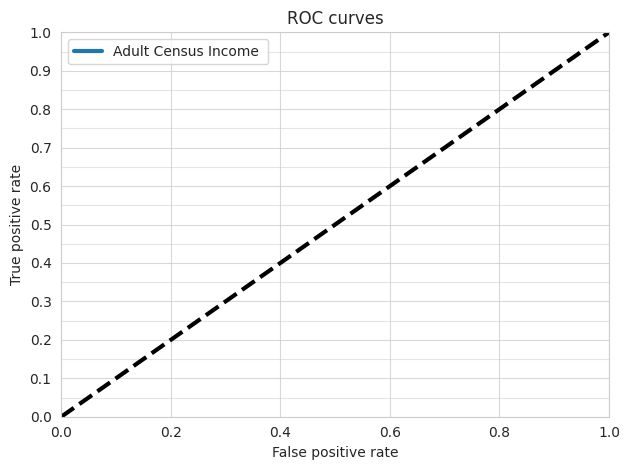

In [ ]:
from ludwig.visualize import roc_curves

roc_curves(
    [predictions['income']['probabilities']],
    eval_df['income'],
    preprocessed_data[-1],
    'income',
    '1',
    model_names=["Adult Census Income"],
    output_directory='visualization',
    file_format='png'
)

## Binary Threshold Metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

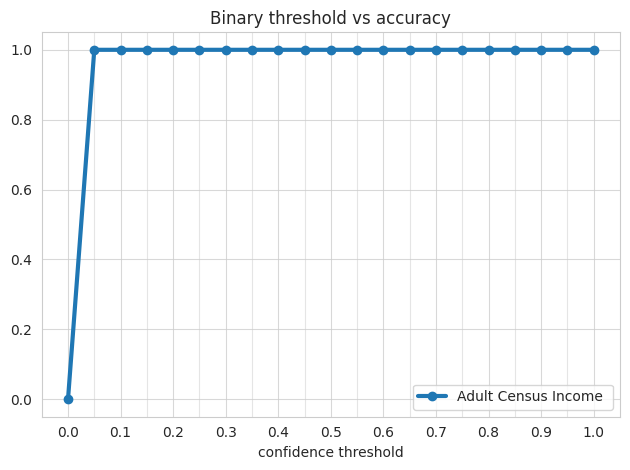

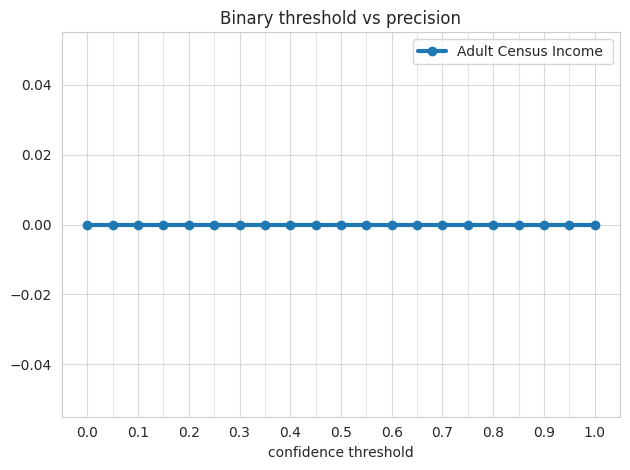

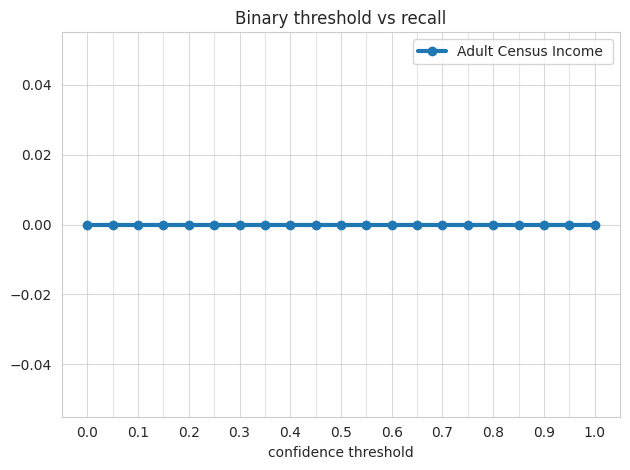

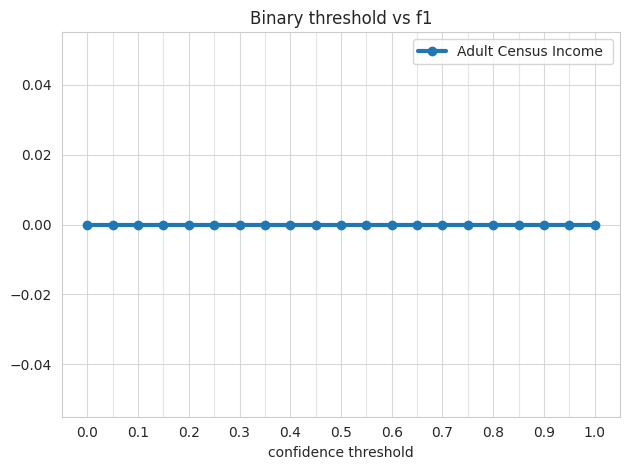

In [ ]:
from ludwig.visualize import binary_threshold_vs_metric

binary_threshold_vs_metric(
    [predictions["income"]["probabilities"]],
    eval_df["income"],
    preprocessed_data[-1],
    "income",
    ["accuracy", "precision", "recall", "f1"],
    1,
    model_names=["Adult Census Income"],
    output_directory="visualization",
    file_format="png",
)


## Predict

In [ ]:
predictions, prediction_results = model.predict(dataset=eval_df, skip_save_predictions=False, output_directory="predictions")


Prediction: 100%|██████████| 16/16 [00:00<00:00, 495.28it/s]

INFO:ludwig.api:Saved to: predictions
INFO:ludwig.api:Finished predicting in: 0.20s.


In [ ]:
predictions.head()

,income_probabilities,income_predictions,income_probabilities_<=50K,income_probabilities_>50K,income_probability
0,"[1.0, 1.5470658426280192e-21]",<=50K,1.0,1.547066e-21,1.0
1,"[1.0, 3.0908847590136976e-20]",<=50K,1.0,3.090885e-20,1.0
2,"[1.0, 4.602772589284076e-19]",<=50K,1.0,4.602773e-19,1.0
3,"[1.0, 2.2810128906809225e-22]",<=50K,1.0,2.281013e-22,1.0
4,"[0.9999999999992629, 7.370624293193129e-13]",<=50K,1.0,7.370624e-13,1.0
